In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt

In [4]:
from rqc.CT_quantum_stat_mech import * 

In [5]:
from rqc.CT_quantum_stat_mech_O1 import *

In [6]:
ct = CT_quantum_stat_mech(L=4)

In [7]:
ct.vec+=1

In [8]:
ct.Bernouli()

In [9]:
ct.control()

In [10]:
ct.vec

array([1., 2., 2., 0.])

In [11]:
ct.variance()

np.float64(-0.3125)

In [12]:
ct.variance_FDW()

np.float64(0.25)

In [13]:
ct_ = CT_quantum_stat_mech_O1(L=4)

In [14]:
ct_.FDW=4

In [15]:
ct_.variance()

0.25

In [16]:
ct_.variance_FDW()

1.43359375

In [111]:
def run(L,p,seed_C=0):
    ct = CT_quantum_stat_mech(L=L,seed_C=seed_C)
    for i in range(2*ct.L**2):
    # for i in range(4*ct.L**2):
        ct.random_circuit(p=p)
    var_Mz, var_FDW = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [66]:
def run_T(L,p,seed_C=0):
    ct = CT_quantum_stat_mech(L=L,seed_C=seed_C)
    Tmax = 2*ct.L**2
    var_Mz= np.zeros(Tmax+1,)
    var_FDW= np.zeros(Tmax+1,)
    var_Mz[0], var_FDW[0] = ct.variance(), ct.variance_FDW()
    for i in range(Tmax):
        ct.random_circuit(p=p)
        var_Mz[i+1], var_FDW[i+1] = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [183]:
def run_O1(L,p,seed_C=0):
    ct = CT_quantum_stat_mech_O1(L=L,seed_C=seed_C)
    for i in range(2*ct.L**2):
    # for i in range(4*ct.L**2):
        ct.random_circuit(p=p)
    var_Mz, var_FDW = ct.variance(), ct.variance_FDW()
    return var_Mz, var_FDW

In [18]:
def run_O1_T(L,p,seed_C=0):
    ct = CT_quantum_stat_mech_O1(L=L,seed_C=seed_C)
    Tmax = 2*ct.L**2
    var_Mz= np.zeros(Tmax+1,)
    var_FDW= np.zeros(Tmax+1,)
    var_Mz[0], var_FDW[0] = ct.variance(), ct.variance_FDW()
    for i in range(Tmax):
        ct.random_circuit(p=p)
        var_Mz[i+1] =ct.variance()
        var_FDW[i+1] = ct.variance_FDW()
    return var_Mz, var_FDW

In [203]:
var_Mz, var_FDW = run_T(L=100,p=0.5,seed_C=0)

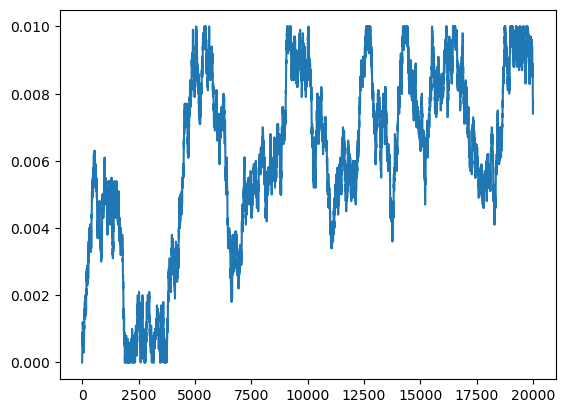

In [204]:
plt.plot(var_Mz)

In [227]:
var_Mz, var_FDW = run_O1_T(L=100,p=0.5,seed_C=0)

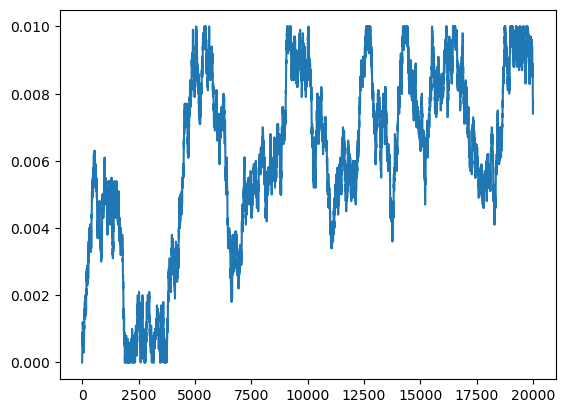

In [228]:
plt.plot(var_Mz)

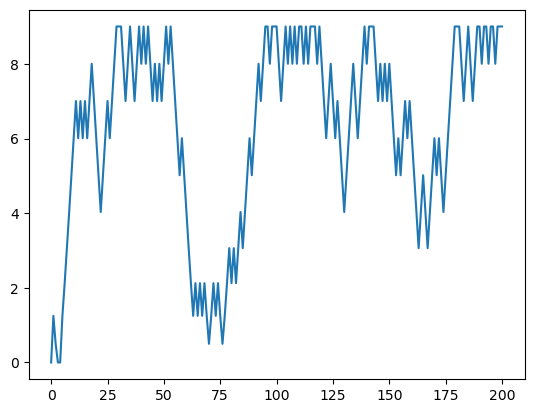

In [69]:
plt.plot(var_FDW)

In [19]:
L_list=[10,20,30,40]
# p_list = (np.linspace(.2,.8,19))
p_list= [0.5]
seed_list = np.arange(10000)
var_Mz_list_short={}
var_FDW_list_short = {} 
for L in (L_list):
    var_Mz_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    var_FDW_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list_short[L][p_idx,i], var_FDW_list_short[L][p_idx,i] = run_O1_T(L,p,seed)


10000it [00:01, 9181.30it/s]
10000it [00:03, 2579.04it/s]
10000it [00:08, 1151.24it/s]
10000it [00:15, 640.69it/s]


In [ ]:
L_list=[10,20,30,40]
# p_list = (np.linspace(.2,.8,19))
p_list= [0.5]
seed_list = np.arange(10000)
var_Mz_list_short={}
var_FDW_list_short = {} 
for L in (L_list):
    var_Mz_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    var_FDW_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list_short[L][p_idx,i], var_FDW_list_short[L][p_idx,i] = run_O1_T(L,p,seed)


5000it [00:02, 2411.58it/s]
5000it [00:07, 692.17it/s]
5000it [00:20, 247.63it/s]
5000it [00:33, 149.61it/s]


In [236]:
from joblib import Parallel, delayed

L_list=[10,20,30,40]
p_list= [0.5]
seed_list = np.arange(100000)
var_Mz_list_short={}
var_FDW_list_short = {} 

for L in L_list:
    var_Mz_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    var_FDW_list_short[L] = np.zeros((len(p_list),len(seed_list),2*L**2+1 ))
    for p_idx,p in enumerate(p_list):
        # Parallelize over seeds
        results = Parallel(n_jobs=-1)(
            delayed(run_O1_T)(L, p, seed) for seed in tqdm(seed_list, desc=f'L={L}, p={p}')
        )
        # Unpack results
        for i, (var_Mz, var_FDW) in enumerate(results):
            var_Mz_list_short[L][p_idx,i] = var_Mz
            var_FDW_list_short[L][p_idx,i] = var_FDW

L=40, p=0.5: 100%|██████████| 100000/100000 [02:47<00:00, 598.15it/s]


In [237]:
var_Mz_list_short[10].shape

(1, 100000, 201)

(1, 1000)

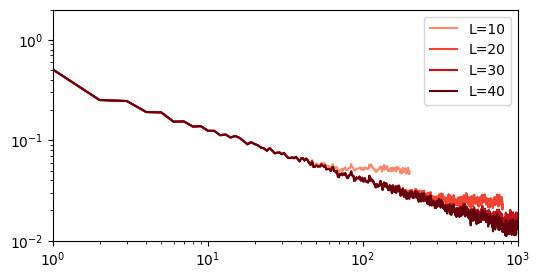

In [20]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]==0).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-2,2)
plt.xlim(1,1000)


(1, 1000)

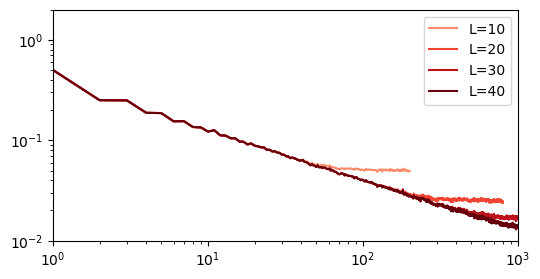

In [243]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)
    y = (var_FDW_list_short[L][0]==0).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-2,2)
plt.xlim(1,1000)


(1, 1000)

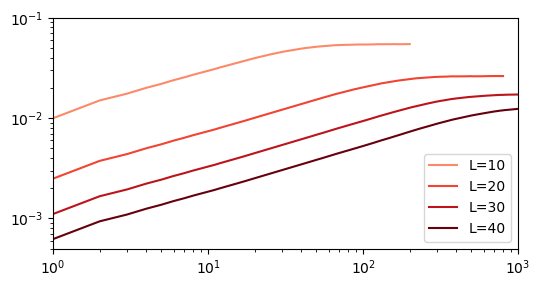

In [250]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(.5e-3,1e-1)
plt.xlim(1,1000)


(1, 2000)

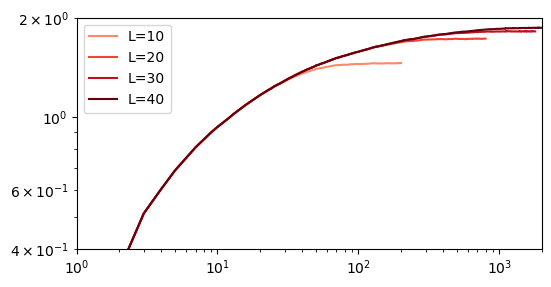

In [258]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)+1
    y = (var_FDW_list_short[L][0]).mean(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_ylim(.5e-3,1e-1)
ax.set_ylim(.4,2)

ax.set_xlim(1,2000)


(1, 1000)

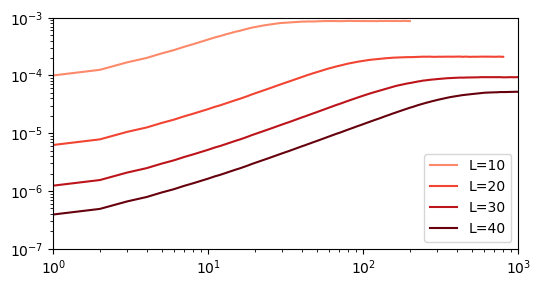

In [254]:
fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    # plt.plot((var_Mz_list_short[L][0]==0).mean(axis=0))
    x = np.arange(2*L**2+1)
    y = (var_Mz_list_short[L][0]).var(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-7,1e-3)
plt.xlim(1,1000)


(1, 2000)

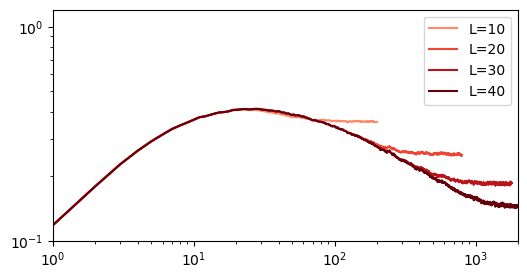

In [265]:

fig,ax=plt.subplots(figsize=(6,3))
color_list = plt.cm.Reds(np.linspace(0.4,1,len(L_list)))
for L, color in zip(L_list, color_list):
    x = np.arange(2*L**2+1)
    y = (var_FDW_list_short[L][0]).var(axis=0)
    ax.plot(x,y, label=f'L={L}', color=color)
    # plt.plot(x/L**2, y*L)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_ylim(.5e-3,1e-1)
# ax.set_ylim(.4,2)
ax.set_ylim(1e-1,1.2)

ax.set_xlim(1,2000)


In [269]:
import pickle

In [270]:
with open('stat_mech_Mz_FDW.pickle', 'wb') as f:
    pickle.dump({'var_Mz':var_Mz_list_short, 'var_FDW':var_FDW_list_short}, f)

In [271]:
import lzma
with lzma.open('stat_mech_Mz_FDW.xz', 'wb') as f:
    pickle.dump({'var_Mz':var_Mz_list_short, 'var_FDW':var_FDW_list_short}, f)

In [ ]:
var_FDW_list_short

In [25]:
L_list=[10,20]
# p_list = (np.linspace(.2,.8,19))
p_list = [0.5]
seed_list = np.arange(2000)
var_Mz_list = np.zeros((len(L_list),len(p_list),len(seed_list)))
var_FDW_list = np.zeros((len(L_list),len(p_list),len(seed_list)))

for L_idx, L in enumerate(L_list):
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list[L_idx,p_idx,i], var_FDW_list[L_idx,p_idx,i] = run(L,p,seed)
    

0it [00:00, ?it/s]

1it [00:04,  4.53s/it]
1it [00:04,  4.53s/it]
1it [00:14, 14.90s/it]


In [27]:
var_Mz_list.shape

(2, 1, 2000)

In [24]:
p_list[9]

0.5

In [59]:
L_list=[10,20,30]
p_list = (np.linspace(.2,.8,19))
seed_list = np.arange(100)
var_list = np.zeros((len(L_list),len(p_list),len(seed_list)))
for L_idx, L in enumerate(L_list):
    for p_idx,p in tqdm(enumerate(p_list)):
        for i,seed in enumerate(seed_list):
            var_list[L_idx,p_idx,i] = run(L,p,seed)
    

19it [00:07,  2.69it/s]
19it [00:28,  1.50s/it]
19it [00:58,  3.08s/it]


In [112]:
L_list=[10,20,]
# p_list = (np.linspace(.2,.8,19))
p_list= [0.5]
seed_list = np.arange(10000)
var_Mz_list_short = np.zeros((len(L_list),len(p_list),len(seed_list)))
var_FDW_list_short = np.zeros((len(L_list),len(p_list),len(seed_list)))
for L_idx, L in enumerate(L_list):
    for p_idx,p in (enumerate(p_list)):
        for i,seed in tqdm(enumerate(seed_list)):
            var_Mz_list_short[L_idx,p_idx,i], var_FDW_list_short[L_idx,p_idx,i] = run(L,p,seed)


0it [00:00, ?it/s]

10000it [00:20, 482.65it/s]
10000it [01:21, 122.50it/s]


In [58]:
(var_Mz_list_short[0,0]==0).mean()

np.float64(0.0482)

In [57]:
(var_Mz_list_short[1,0]==0).mean()

np.float64(0.0226)

In [47]:
(var_Mz_list_short[2,0]==0).mean()

np.float64(0.0149)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_509355/2348753722.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma^2$')


Text(0, 0.5, 'PDF')

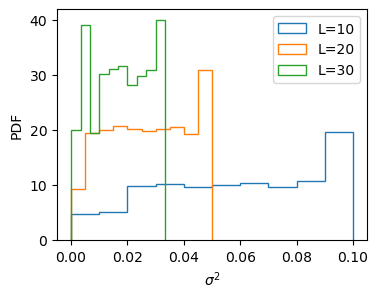

In [39]:
fig,ax=plt.subplots(figsize=(4,3))
for i in range(0,3):
    (ax.hist(var_Mz_list_short[i,0],label=f'L={L_list[i]}',histtype='step',bins=10,density=True))
ax.legend()

ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('PDF')
# fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_0.5.pdf',bbox_inches='tight')

In [119]:
(var_FDW_list_short[0,0]==0).mean()

np.float64(0.0482)

In [ ]:
(var_FDW_list_short[1,0]==0).mean()

np.float64(0.0226)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_509355/2200966342.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma^2$')


Text(0, 0.5, 'PDF')

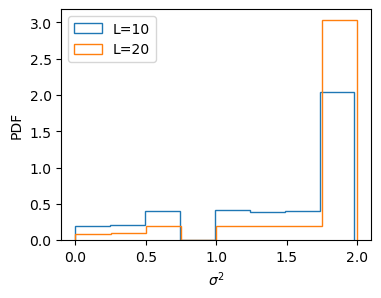

In [117]:
fig,ax=plt.subplots(figsize=(4,3))
for i in range(0,2):
    (ax.hist(var_FDW_list_short[i,0],label=f'L={L_list[i]}',histtype='step',bins=8,density=True))
ax.legend()

ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('PDF')
# fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_0.5.pdf',bbox_inches='tight')

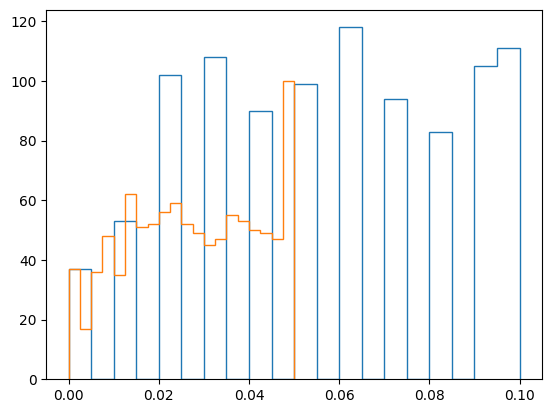

In [36]:
for i in range(2):
    (plt.hist(var_list[i,0],label=f'L={L_list[i]}',histtype='step',bins=20))

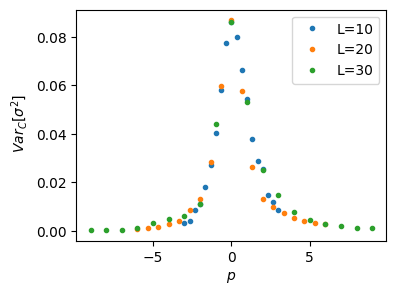

In [68]:
fig,ax=plt.subplots(figsize=(4,3))
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    ax.plot(x,y,'.',label=f'L={L}')
ax.legend()
ax.set_xlabel('$p$')
ax.set_ylabel(r' $Var_C[\sigma^2]$')

fig.savefig('../Paper_CIPT/Fig/circ_fluct_traj_fluct_p.pdf',bbox_inches='tight')
# ax.xlabel('$(p-0.5)L$')
# ax.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

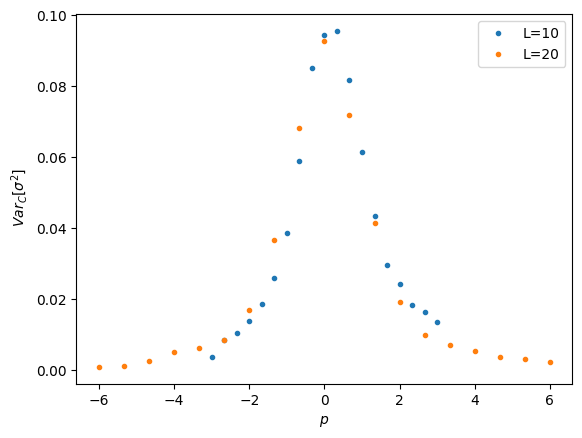

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

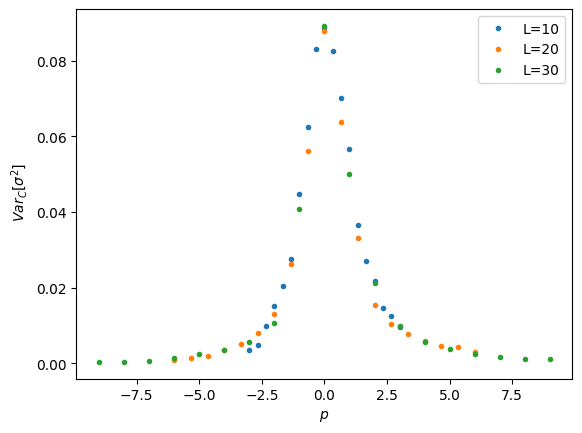

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

Text(0, 0.5, ' $Var_C[\\sigma^2]$')

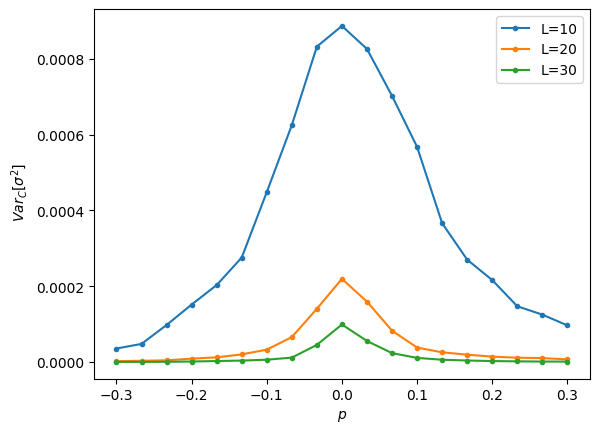

In [ ]:
for L_idx, L in enumerate(L_list):
    x = (p_list-0.5)
    y = var_list[L_idx].var(axis=1)
    # x = (p_list-0.5)*L
    # y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.-',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
# plt.xlabel('$(p-0.5)L$')
# plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

In [91]:
for L_idx, L in enumerate(L_list):
    # x = (p_list-0.5)
    # y = var_list[L_idx].var(axis=1)
    x = (p_list-0.5)*L
    y = var_list[L_idx].var(axis=1)*L**2
    plt.plot(x,y,'.-',label=f'L={L}')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r' $Var_C[\sigma^2]$')
plt.xlabel('$(p-0.5)L$')
plt.ylabel(r' $Var_C[\sigma^2] ~L^2$')

[0.1,
 0.020000000000000004,
 0.07,
 0.1,
 0.1,
 0.0,
 0.03,
 0.05,
 0.060000000000000005,
 0.05,
 0.0,
 0.1,
 0.05,
 0.1,
 0.03,
 0.08,
 0.0,
 0.07,
 0.1,
 0.09000000000000001]

In [17]:
ct.T_tensor(ct.T_tensor(ct.vec,left=True))

array([[[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]])

In [31]:
ct.R_tensor(ct.vec)

array([[[[0.125, 0.   ],
         [0.125, 0.   ]],

        [[0.125, 0.   ],
         [0.125, 0.   ]]],


       [[[0.125, 0.   ],
         [0.125, 0.   ]],

        [[0.125, 0.   ],
         [0.125, 0.   ]]]])

In [49]:
z=np.array([1,2,3])

In [51]:
np.roll(z,-1)

array([2, 3, 1])

In [2]:
from scipy.special import comb


In [45]:
L=20
x=np.arange(0,21)


p = comb(L,x)/2**L
sigma2=1/L-x/L**2



In [46]:
import matplotlib.pyplot as plt

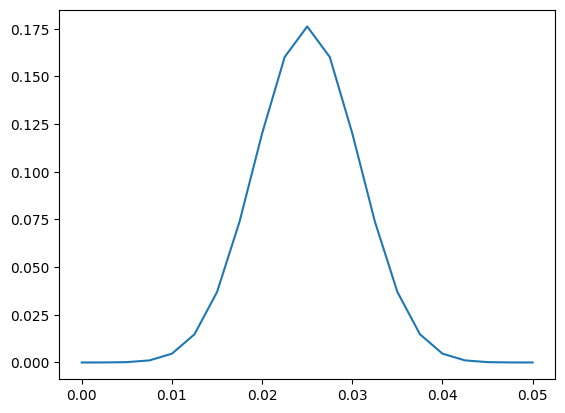

In [48]:
plt.plot(sigma2,p)

In [51]:
def pmz(sigma2,t,L,p):
    x=L/2-L**2*sigma2
    # print((t+x)/2)
    return comb( t,(t+x)/2) * p ** ((t+x)/2) * (1-p) ** ((t-x)/2)



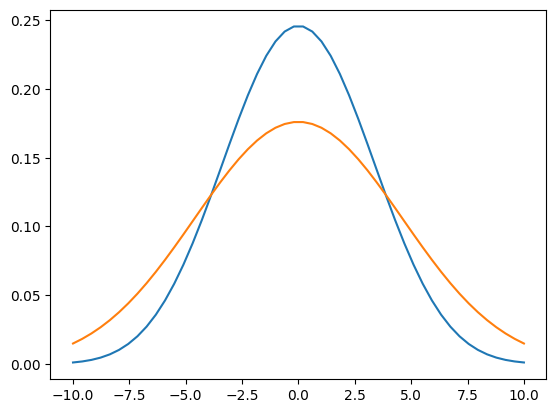

In [56]:
plt.plot(np.linspace(-10,10,),[pdf(x,t=10,p=0.5) for x in np.linspace(-10,10,)])
plt.plot(np.linspace(-10,10,),[pdf(x,t=20,p=0.5) for x in np.linspace(-10,10,)])

In [27]:
import numpy as np

In [31]:
import matplotlib.pyplot as plt

(0.0, 0.0835643918604102)

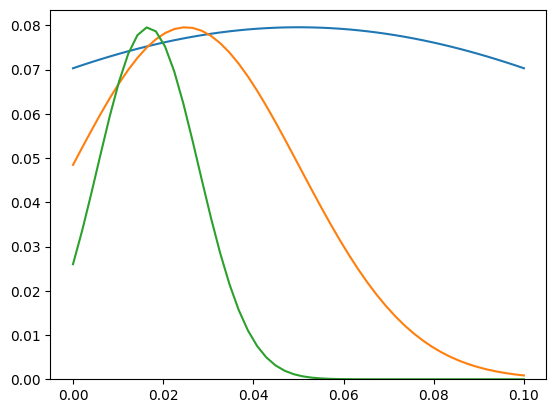

In [61]:
sigma_list = np.linspace(0,1/10)
plt.plot(sigma_list , [pmz(x,100,10,0.5) for x in sigma_list])
sigma_list = np.linspace(0,1/10)
plt.plot(sigma_list , [pmz(x,100,20,0.5) for x in sigma_list])
plt.plot(sigma_list , [pmz(x,100,30,0.5) for x in sigma_list])
plt.ylim(0,None)

# second moment SM model

In [1]:
from joblib import Parallel, delayed


In [2]:
# Import the k=2 model
from rqc.CT_quantum_stat_mech import CT_quantum_stat_mech
from rqc.CT_quantum_stat_mech_k2 import CT_quantum_stat_mech_k2

In [3]:
import numpy as np
from tqdm import tqdm

In [4]:
def compute_k1_k2_moments_time_dependent(p, L, seed):
    """
    Wrapper function to compute time-dependent observables from both k=1 and k=2 models.
    
    For each time step, computes:
    - Var_ρ(O) = <O²>_ρ - <O>_ρ²  (variance in the quantum state ρ)
    - Moments for k=2 model (for computing other quantities)
    
    Parameters:
    -----------
    p : float
        Control probability
    L : int
        System size
    seed : int
        Random seed for this trajectory
        
    Returns:
    --------
    results : dict
        Dictionary containing time series (length T+1 = 2*L²+1):
        - 'var_FDW_k1': Var_ρ(FDW) at each time from k=1 model
        - 'var_Mz_k1': Var_ρ(Mz) at each time from k=1 model
        - 'FDW2_k2': <FDW⊗FDW> at each time from k=2 model (before weighting)
        - 'Mz2_k2': <Mz⊗Mz> at each time from k=2 model (before weighting)
        - 'weight_k2': trajectory weights at each time
        - 'log_weight_k2': log of trajectory weights at each time
    """
    # Initialize both models with the same seed
    k1 = CT_quantum_stat_mech(L=L, seed=seed)
    k2 = CT_quantum_stat_mech_k2(L=L, seed=seed)
    
    # Time steps: T = 2*L^2
    T = 2 * L**2
    
    # Initialize arrays to store time series
    var_FDW_k1 = np.zeros(T+1)
    var_Mz_k1 = np.zeros(T+1)
    FDW2_k2 = np.zeros(T+1)
    Mz2_k2 = np.zeros(T+1)
    weight_k2 = np.zeros(T+1)
    log_weight_k2 = np.zeros(T+1)
    
    # Compute initial observables (t=0)
    # For k=1: Var_ρ(O) = <O²>_ρ - <O>_ρ²
    FDW_mean_1 = k1.mean_FDW_moment(n=1)
    FDW_mean_2 = k1.mean_FDW_moment(n=2)
    var_FDW_k1[0] = FDW_mean_2 - FDW_mean_1**2
    
    Mz_mean_1 = k1.mean_Mz_moment(n=1)
    Mz_mean_2 = k1.mean_Mz_moment(n=2)
    var_Mz_k1[0] = Mz_mean_2 - Mz_mean_1**2
    
    # For k=2: moments and weights
    FDW2_k2[0] = k2.mean_FDW_moment(n=2)
    Mz2_k2[0] = k2.mean_Mz_moment(n=2)
    weight_k2[0] = k2.get_weight()
    log_weight_k2[0] = k2.get_log_weight()
    
    # Time evolution
    for t in range(T):
        # Apply one gate to both models
        k1.random_circuit(p)
        k2.random_circuit(p)
        
        # Compute observables from k=1
        FDW_mean_1 = k1.mean_FDW_moment(n=1)
        FDW_mean_2 = k1.mean_FDW_moment(n=2)
        var_FDW_k1[t+1] = FDW_mean_2 - FDW_mean_1**2
        
        Mz_mean_1 = k1.mean_Mz_moment(n=1)
        Mz_mean_2 = k1.mean_Mz_moment(n=2)
        var_Mz_k1[t+1] = Mz_mean_2 - Mz_mean_1**2
        
        # Compute observables from k=2
        FDW2_k2[t+1] = k2.mean_FDW_moment(n=2)
        Mz2_k2[t+1] = k2.mean_Mz_moment(n=2)
        weight_k2[t+1] = k2.get_weight()
        log_weight_k2[t+1] = k2.get_log_weight()
    
    return {
        'var_FDW_k1': var_FDW_k1,
        'var_Mz_k1': var_Mz_k1,
        'FDW2_k2': FDW2_k2,
        'Mz2_k2': Mz2_k2,
        'weight_k2': weight_k2,
        'log_weight_k2': log_weight_k2
    }

In [ ]:
# Parallelized computation with time dependence
# Adjust L_list, p_list, and n_seeds as needed

L_list = [10, 20,30]
p_list = [0.5]
n_seeds = 10000  # Number of circuit realizations

# Store results
results_time_dict = {}

for L in L_list:
    results_time_dict[L] = {}
    for p in p_list:
        print(f"\n=== Running time-dependent simulations for L={L}, p={p} ===")
        
        seed_list = np.arange(n_seeds)
        
        # Parallelize over different circuit realizations (seeds)
        results = Parallel(n_jobs=-1)(
            delayed(compute_k1_k2_moments_time_dependent)(p, L, seed) 
            for seed in tqdm(seed_list, desc=f'L={L}, p={p}')
        )
        
        # Store results
        results_time_dict[L][p] = results
        
        print(f"Completed {n_seeds} time-dependent trajectories for L={L}, p={p}")


=== Running time-dependent simulations for L=10, p=0.5 ===


L=10, p=0.5:  25%|███████████████████████████████████████████████████                                                                                                                                                           | 2480/10000 [00:07<00:24, 302.40it/s]

In [ ]:
# Compute circuit-averaged time-dependent observables
# This computes E_C[Var_ρ_C(O)](t) - the circuit-averaged variance in the quantum state

averaged_time_results = {}

for L in results_time_dict.keys():
    averaged_time_results[L] = {}
    for p in results_time_dict[L].keys():
        results = results_time_dict[L][p]
        n_circuits = len(results)
        T = 2 * L**2
        
        print(f"\n=== Computing time-dependent circuit averages for L={L}, p={p} ===")
        
        # Extract time series arrays from all circuits
        # Each has shape (n_circuits, T+1)
        var_FDW_k1_array = np.array([r['var_FDW_k1'] for r in results])
        var_Mz_k1_array = np.array([r['var_Mz_k1'] for r in results])
        FDW2_k2_array = np.array([r['FDW2_k2'] for r in results])
        Mz2_k2_array = np.array([r['Mz2_k2'] for r in results])
        weight_k2_array = np.array([r['weight_k2'] for r in results])
        log_weight_k2_array = np.array([r['log_weight_k2'] for r in results])
        
        # Compute circuit averages at each time step
        # E_C[Var_ρ_C(FDW)](t) and E_C[Var_ρ_C(Mz)](t)
        mean_var_FDW_k1 = np.mean(var_FDW_k1_array, axis=0)  # Shape: (T+1,)
        mean_var_Mz_k1 = np.mean(var_Mz_k1_array, axis=0)    # Shape: (T+1,)
        
        # Standard deviation across circuits (for error bars)
        std_var_FDW_k1 = np.std(var_FDW_k1_array, axis=0)
        std_var_Mz_k1 = np.std(var_Mz_k1_array, axis=0)
        
        # Weighted averages from k=2 model at each time step
        # <O⊗O>_weighted(t) = sum_c w_c(t) * Tr(ρ_c^(2)(t) (O⊗O)) / sum_c w_c(t)
        sum_weights = np.sum(weight_k2_array, axis=0)  # Shape: (T+1,)
        mean_FDW2_k2_weighted = np.sum(FDW2_k2_array * weight_k2_array, axis=0) / sum_weights
        mean_Mz2_k2_weighted = np.sum(Mz2_k2_array * weight_k2_array, axis=0) / sum_weights
        
        # Store results
        averaged_time_results[L][p] = {
            'time': np.arange(T+1),
            'E_C_var_FDW': mean_var_FDW_k1,
            'E_C_var_Mz': mean_var_Mz_k1,
            'std_var_FDW': std_var_FDW_k1,
            'std_var_Mz': std_var_Mz_k1,
            'mean_FDW2_k2_weighted': mean_FDW2_k2_weighted,
            'mean_Mz2_k2_weighted': mean_Mz2_k2_weighted,
            'sum_weights': sum_weights,
            'mean_weight': np.mean(weight_k2_array, axis=0),
            'mean_log_weight': np.mean(log_weight_k2_array, axis=0),
            'n_circuits': n_circuits
        }
        
        # Print summary at final time
        print(f"Number of circuits: {n_circuits}")
        print(f"Time steps: 0 to {T}")
        print(f"\nAt final time t={T}:")
        print(f"  E_C[Var_ρ(FDW)] = {mean_var_FDW_k1[-1]:.6f} ± {std_var_FDW_k1[-1]:.6f}")
        print(f"  E_C[Var_ρ(Mz)] = {mean_var_Mz_k1[-1]:.6f} ± {std_var_Mz_k1[-1]:.6f}")
        print(f"  Sum of k=2 weights: {sum_weights[-1]:.6e}")
        print(f"  Mean k=2 weight: {np.mean(weight_k2_array[:, -1]):.6e}")
        print(f"  Mean k=2 log-weight: {np.mean(log_weight_k2_array[:, -1]):.6f}")


=== Computing time-dependent circuit averages for L=10, p=0.5 ===
Number of circuits: 10000
Time steps: 0 to 200

At final time t=200:
  E_C[Var_ρ(FDW)] = 1.460506 ± 0.596519
  E_C[Var_ρ(Mz)] = 0.054566 ± 0.029369
  Sum of k=2 weights: 1.592838e+03
  Mean k=2 weight: 1.592838e-01
  Mean k=2 log-weight: -12.082153

=== Computing time-dependent circuit averages for L=20, p=0.5 ===
Number of circuits: 10000
Time steps: 0 to 800

At final time t=800:
  E_C[Var_ρ(FDW)] = 1.737135 ± 0.491097
  E_C[Var_ρ(Mz)] = 0.026364 ± 0.014449
  Sum of k=2 weights: 2.350092e-02
  Mean k=2 weight: 2.350092e-06
  Mean k=2 log-weight: -43.167543

=== Computing time-dependent circuit averages for L=30, p=0.5 ===
Number of circuits: 10000
Time steps: 0 to 1800

At final time t=1800:
  E_C[Var_ρ(FDW)] = 1.820411 ± 0.425434
  E_C[Var_ρ(Mz)] = 0.017241 ± 0.009613
  Sum of k=2 weights: 1.369319e-17
  Mean k=2 weight: 1.369319e-21
  Mean k=2 log-weight: -93.708919


In [ ]:
import matplotlib.pyplot as plt

(1, np.float64(2618.4008323672315))

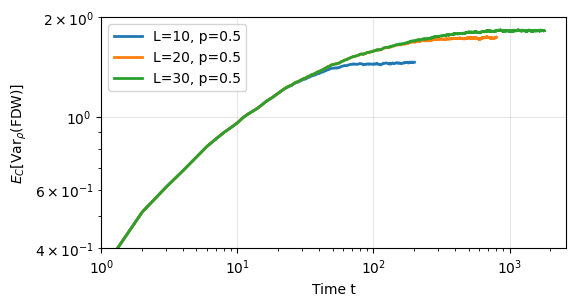

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

# Plot FDW variance
ax = axes
for L in L_list:
    for p in p_list:
        data = averaged_time_results[L][p]
        t = data['time']
        y = data['E_C_var_FDW']
        y_std = data['std_var_FDW']
        
        ax.plot(t, y, label=f'L={L}, p={p}', linewidth=2)
        # Optionally add error band
        # ax.fill_between(t, y-y_std, y+y_std, alpha=0.2)

ax.set_xlabel('Time t', )
ax.set_ylabel(r'$E_C[\mathrm{Var}_\rho(\mathrm{FDW})]$', )
# ax.set_title('Circuit-averaged FDW variance',)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.4,2)
ax.set_xlim(1,None)

(1, 1000.0)

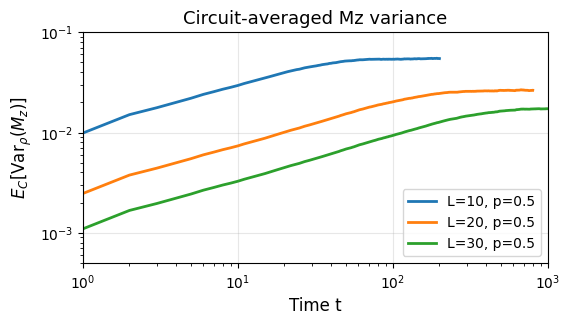

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

# Plot FDW variance
ax = axes
for L in L_list:
    for p in p_list:
        data = averaged_time_results[L][p]
        t = data['time']
        y = data['E_C_var_Mz']
        y_std = data['std_var_Mz']
        
        ax.plot(t, y, label=f'L={L}, p={p}', linewidth=2)
        # Optionally add error band
        # ax.fill_between(t, y-y_std, y+y_std, alpha=0.2)

ax.set_xlabel('Time t', fontsize=12)
ax.set_ylabel(r'$E_C[\mathrm{Var}_\rho(M_z)]$', fontsize=12)
ax.set_title('Circuit-averaged Mz variance', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.5e-3,1e-1)
ax.set_xlim(1,1e3)

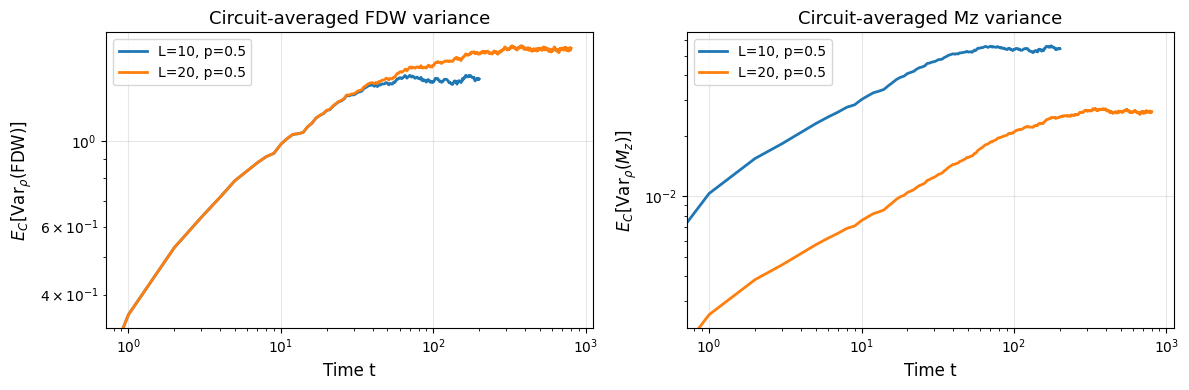

In [ ]:
# Example: Plot time-dependent E_C[Var_ρ_C(O)](t)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot FDW variance
ax = axes[0]
for L in L_list:
    for p in p_list:
        data = averaged_time_results[L][p]
        t = data['time']
        y = data['E_C_var_FDW']
        y_std = data['std_var_FDW']
        
        ax.plot(t, y, label=f'L={L}, p={p}', linewidth=2)
        # Optionally add error band
        # ax.fill_between(t, y-y_std, y+y_std, alpha=0.2)

ax.set_xlabel('Time t', fontsize=12)
ax.set_ylabel(r'$E_C[\mathrm{Var}_\rho(\mathrm{FDW})]$', fontsize=12)
ax.set_title('Circuit-averaged FDW variance', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

# Plot Mz variance
ax = axes[1]
for L in L_list:
    for p in p_list:
        data = averaged_time_results[L][p]
        t = data['time']
        y = data['E_C_var_Mz']
        y_std = data['std_var_Mz']
        
        ax.plot(t, y, label=f'L={L}, p={p}', linewidth=2)
        # Optionally add error band
        # ax.fill_between(t, y-y_std, y+y_std, alpha=0.2)

ax.set_xlabel('Time t', fontsize=12)
ax.set_ylabel(r'$E_C[\mathrm{Var}_\rho(M_z)]$', fontsize=12)
ax.set_title('Circuit-averaged Mz variance', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()